<a href="https://colab.research.google.com/github/SHIVANSH3SRIVASTAVA/CGAN_CIFAR-10/blob/main/CGAN_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np

# 1. Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# 2. Normalize the x_train and x_test image pixel values
x_train = (x_train.astype('float32') / 127.5) - 1
x_test = (x_test.astype('float32') / 127.5) - 1

# 3. Determine the number of unique classes
num_classes = len(np.unique(y_train))

print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of x_test: {x_test.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Number of classes: {num_classes}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Shape of x_train: (50000, 32, 32, 3)
Shape of y_train: (50000, 1)
Shape of x_test: (10000, 32, 32, 3)
Shape of y_test: (10000, 1)
Number of classes: 10


In [2]:
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes)

print(f"Shape of y_train_one_hot: {y_train_one_hot.shape}")
print(f"Shape of y_test_one_hot: {y_test_one_hot.shape}")

Shape of y_train_one_hot: (50000, 10)
Shape of y_test_one_hot: (10000, 10)


In [3]:
from tensorflow.keras.layers import Input, Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Embedding, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# 2. Define the input shape for the latent noise vector
latent_dim = 100

print(f"Latent dimension defined as: {latent_dim}")

Latent dimension defined as: 100


In [4]:
def build_generator(latent_dim, num_classes):
    # Input for latent noise vector
    noise_input = Input(shape=(latent_dim,), name='noise_input')
    # Input for class labels
    label_input = Input(shape=(1,), name='label_input')

    # Embedding for the class label
    # The output dimension of the embedding layer can be adjusted, here we use latent_dim
    label_embedding = Embedding(num_classes, latent_dim)(label_input)
    label_embedding = Dense(latent_dim)(label_embedding)
    # Reshape the embedding to match the noise input for concatenation
    label_embedding = Reshape((latent_dim,))(label_embedding)

    # Concatenate noise and label embedding
    merged_input = Concatenate()([noise_input, label_embedding])

    # First dense layer to project to a size that can be reshaped for Conv2DTranspose
    # We want to output a 4x4x256 feature map initially
    gen = Dense(4 * 4 * 256, use_bias=False)(merged_input)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((4, 4, 256))(gen)

    # Upsampling block 1: 4x4x256 -> 8x8x128
    gen = Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)

    # Upsampling block 2: 8x8x128 -> 16x16x64
    gen = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)

    # Upsampling block 3: 16x16x64 -> 32x32x3 (output image)
    gen = Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', activation='tanh', use_bias=False)(gen)

    # Create the Generator model
    generator = Model(inputs=[noise_input, label_input], outputs=gen, name='generator')
    return generator

# Instantiate the generator
generator = build_generator(latent_dim, num_classes)
generator.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ label_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 100)    │      1,000 │ label_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 100)    │     10,100 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ noise_input         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 100)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 200)       │          0 │ noise_input[0][0… │
│ (Concatenate)       │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4096)      │    819,200 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 4096)      │          0 │ dense_1[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 4, 4, 256) │          0 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 8, 8, 128) │    819,200 │ reshape_1[0][0]   │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 8, 8, 128) │          0 │ conv2d_transpose… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 16, 16,    │    204,800 │ leaky_re_lu_1[0]… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 32, 32, 3) │      4,800 │ leaky_re_lu_2[0]… │
│ (Conv2DTranspose)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,859,100 (7.09 MB)

 Trainable params: 1,859,100 (7.09 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
def build_discriminator(img_shape, num_classes):    # Input for image
    img_input = Input(shape=img_shape, name='image_input')
    # Input for class labels
    label_input = Input(shape=(1,), name='label_input')

    # Embedding for the class label
    # The embedding is then passed through a Dense layer and reshaped to match the spatial dimensions of the image,
    # creating an additional channel that contains class information.
    label_embedding = Embedding(num_classes, img_shape[0] * img_shape[1])(label_input)
    label_embedding = Dense(img_shape[0] * img_shape[1])(label_embedding) # This creates a vector of size H*W
    label_embedding = Reshape((img_shape[0], img_shape[1], 1))(label_embedding) # Reshape to (H, W, 1)

    # Concatenate image and label embedding along the channel dimension
    merged_input = Concatenate()([img_input, label_embedding]) # Resulting shape (H, W, C+1)

    # Downsampling block 1: (H,W,C+1) -> (H/2, W/2, 64)
    dis = Conv2D(64, (5, 5), strides=(2, 2), padding='same')(merged_input)
    dis = LeakyReLU(negative_slope=0.2)(dis) # Using negative_slope as suggested by the warning

    # Downsampling block 2: (H/2, W/2, 64) -> (H/4, W/4, 128)
    dis = Conv2D(128, (5, 5), strides=(2, 2), padding='same')(dis)
    dis = LeakyReLU(negative_slope=0.2)(dis)

    # Downsampling block 3: (H/4, W/4, 128) -> (H/8, W/8, 256)
    dis = Conv2D(256, (5, 5), strides=(2, 2), padding='same')(dis)
    dis = LeakyReLU(negative_slope=0.2)(dis)

    # Flatten the output and apply a dense layer for classification
    dis = Flatten()(dis)
    discriminator_output = Dense(1, activation='sigmoid')(dis)

    # Create the Discriminator model
    discriminator = Model(inputs=[img_input, label_input], outputs=discriminator_output, name='discriminator')
    return discriminator

# Get image shape from x_train (e.g., (32, 32, 3))
img_shape = x_train.shape[1:]

# Instantiate the discriminator
discriminator = build_discriminator(img_shape, num_classes)
discriminator.summary()


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ label_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 1024)   │     10,240 │ label_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1, 1024)   │  1,049,600 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_input         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 32, 32, 1) │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 32, 32, 4) │          0 │ image_input[0][0… │
│ (Concatenate)       │                   │            │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │      6,464 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 16, 16,    │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 128) │    204,928 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 8, 8, 128) │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 4, 256) │    819,456 │ leaky_re_lu_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 4, 4, 256) │          0 │ conv2d_2[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 4096)      │          0 │ leaky_re_lu_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │      4,097 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,094,785 (7.99 MB)

 Trainable params: 2,094,785 (7.99 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
discriminator.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy', metrics=['accuracy'])
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ label_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 1024)   │     10,240 │ label_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1, 1024)   │  1,049,600 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_input         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 32, 32, 1) │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 32, 32, 4) │          0 │ image_input[0][0… │
│ (Concatenate)       │                   │            │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │      6,464 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 16, 16,    │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 128) │    204,928 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 8, 8, 128) │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 4, 256) │    819,456 │ leaky_re_lu_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 4, 4, 256) │          0 │ conv2d_2[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 4096)      │          0 │ leaky_re_lu_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │      4,097 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,094,785 (7.99 MB)

 Trainable params: 2,094,785 (7.99 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# 1. Set the discriminator to be non-trainable during the combined model's training
discriminator.trainable = False

# 2. Define the input layers for the combined model
noise_input = Input(shape=(latent_dim,), name='combined_noise_input')
label_input_combined = Input(shape=(1,), name='combined_label_input') # Renamed to avoid conflict with individual model inputs

# 3. Pass the noise_input and label_input to the generator model to produce fake images
fake_images = generator([noise_input, label_input_combined])

# 4. Pass the fake_images and label_input to the discriminator model to get the discriminator's output for fake images
discriminator_output = discriminator([fake_images, label_input_combined])

# 5. Create the combined CGAN model
cgan = Model(inputs=[noise_input, label_input_combined], outputs=discriminator_output, name='cgan_model')

# 6. Compile the combined CGAN model
cgan.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy')

cgan.summary()
print("CGAN model compiled successfully.")

Model: "cgan_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ combined_noise_inp… │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ combined_label_inp… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ generator           │ (None, 32, 32, 3) │  1,859,100 │ combined_noise_i… │
│ (Functional)        │                   │            │ combined_label_i… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ discriminator       │ (None, 1)         │  2,094,785 │ generator[1][0],  │
│ (Functional)        │                   │            │ combined_label_i… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,953,885 (15.08 MB)

 Trainable params: 1,859,100 (7.09 MB)

 Non-trainable params: 2,094,785 (7.99 MB)

CGAN model compiled successfully.


In [8]:
epochs = 5000
batch_size = 32
sample_interval = 500

print(f"Training parameters defined: epochs={epochs}, batch_size={batch_size}, sample_interval={sample_interval}")

Training parameters defined: epochs=5000, batch_size=32, sample_interval=500


In [9]:
import numpy as np

def train(epochs, batch_size, sample_interval):
    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    # Label smoothing
    valid_smooth = valid * 0.9 + 0.1
    fake_smooth = fake * 0.1

    for epoch in range(epochs):
        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random batch of real images and their labels
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        real_images = x_train[idx]
        real_labels = y_train[idx]

        # Sample noise and generate fake labels
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        # Generate random class labels for the generator to use
        sampled_labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)

        # Generate a batch of new images
        gen_images = generator.predict([noise, sampled_labels], verbose=0)

        # Train the discriminator
        # Train on real images
        d_loss_real = discriminator.train_on_batch([real_images, real_labels], valid_smooth)
        # Train on fake images
        d_loss_fake = discriminator.train_on_batch([gen_images, sampled_labels], fake_smooth)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        # Sample noise and generate labels
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        sampled_labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)

        # Train the generator (to have the discriminator label samples as valid)
        g_loss = cgan.train_on_batch([noise, sampled_labels], valid)

        # Plot the progress
        if epoch % sample_interval == 0:
            print(f"Epoch {epoch}/{epochs} D_loss: {d_loss[0]:.4f}, D_acc: {100*d_loss[1]:.2f}%, G_loss: {g_loss:.4f}")

# Start training
train(epochs, batch_size, sample_interval)

/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0/5000 D_loss: 0.6985, D_acc: 37.50%, G_loss: 0.6930
Epoch 500/5000 D_loss: 1.2756, D_acc: 12.92%, G_loss: 0.1876
Epoch 1000/5000 D_loss: 1.3245, D_acc: 12.95%, G_loss: 0.1631
Epoch 1500/5000 D_loss: 1.3435, D_acc: 12.89%, G_loss: 0.1542
Epoch 2000/5000 D_loss: 1.3611, D_acc: 12.83%, G_loss: 0.1474
Epoch 2500/5000 D_loss: 1.3783, D_acc: 12.82%, G_loss: 0.1416
Epoch 3000/5000 D_loss: 1.3953, D_acc: 12.83%, G_loss: 0.1364
Epoch 3500/5000 D_loss: 1.4123, D_acc: 12.89%, G_loss: 0.1316
Epoch 4000/5000 D_loss: 1.4337, D_acc: 12.86%, G_loss: 0.1263
Epoch 4500/5000 D_loss: 1.4576, D_acc: 12.86%, G_loss: 0.1209


In [10]:
import numpy as np

def train(epochs, batch_size, sample_interval):
    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    # Label smoothing
    valid_smooth = valid * 0.9 + 0.1
    fake_smooth = fake * 0.1

    for epoch in range(epochs):
        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random batch of real images and their labels
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        real_images = x_train[idx]
        real_labels = y_train[idx]

        # Sample noise and generate fake labels
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        # Generate random class labels for the generator to use
        sampled_labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)

        # Generate a batch of new images
        gen_images = generator.predict([noise, sampled_labels], verbose=0)

        # Train the discriminator
        # Train on real images
        d_loss_real = discriminator.train_on_batch([real_images, real_labels], valid_smooth)
        # Train on fake images
        d_loss_fake = discriminator.train_on_batch([gen_images, sampled_labels], fake_smooth)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        # Sample noise and generate labels
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        sampled_labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)

        # Train the generator (to have the discriminator label samples as valid)
        g_loss = cgan.train_on_batch([noise, sampled_labels], valid)

        # Plot the progress
        if epoch % sample_interval == 0:
            print(f"Epoch {epoch}/{epochs} D_loss: {d_loss[0]:.4f}, D_acc: {100*d_loss[1]:.2f}%, G_loss: {g_loss:.4f}")

# Start training
train(epochs, batch_size, sample_interval)

Epoch 0/5000 D_loss: 1.4812, D_acc: 12.84%, G_loss: 0.1159
Epoch 500/5000 D_loss: 1.5041, D_acc: 12.85%, G_loss: 0.1112
Epoch 1000/5000 D_loss: 1.5263, D_acc: 12.88%, G_loss: 0.1070
Epoch 1500/5000 D_loss: 1.5471, D_acc: 12.88%, G_loss: 0.1032
Epoch 2000/5000 D_loss: 1.5658, D_acc: 12.88%, G_loss: 0.0998
Epoch 2500/5000 D_loss: 1.5826, D_acc: 12.88%, G_loss: 0.0968
Epoch 3000/5000 D_loss: 1.5980, D_acc: 12.88%, G_loss: 0.0941
Epoch 3500/5000 D_loss: 1.6123, D_acc: 12.88%, G_loss: 0.0916
Epoch 4000/5000 D_loss: 1.6255, D_acc: 12.87%, G_loss: 0.0894
Epoch 4500/5000 D_loss: 1.6379, D_acc: 12.87%, G_loss: 0.0873


In [11]:
cifar10_class_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

print("CIFAR-10 class names defined.")

CIFAR-10 class names defined.


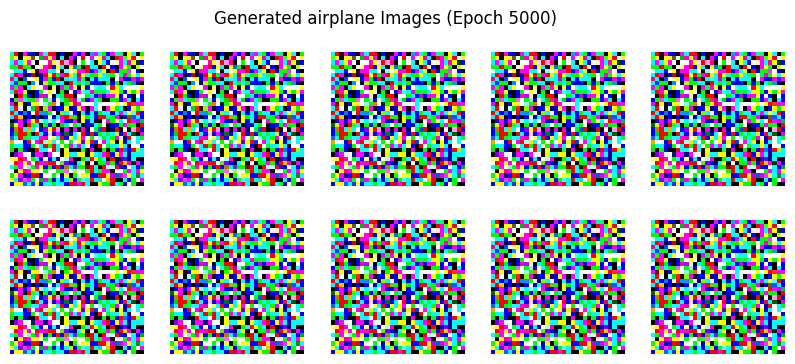

Generated images for class 'airplane' (label 0) at epoch 5000.


In [12]:
import matplotlib.pyplot as plt

def generate_and_save_images(generator, epoch, class_label, latent_dim, num_images_to_generate=10):
    # 3. Generate a batch of random noise vectors
    noise = np.random.normal(0, 1, (num_images_to_generate, latent_dim))

    # 4. Create a corresponding array of class labels
    # Ensure all labels match the input class_label
    # The label needs to be reshaped to (num_images_to_generate, 1) to match the expected input shape for the generator
    generated_labels = np.full((num_images_to_generate, 1), class_label)

    # 5. Use the generator.predict method to generate synthetic images
    gen_images = generator.predict([noise, generated_labels], verbose=0)

    # 6. Denormalize the generated images from [-1, 1] range back to [0, 255] and convert to uint8
    gen_images = 0.5 * gen_images + 0.5  # Scale to [0, 1]
    gen_images = (gen_images * 255).astype(np.uint8)

    # 8. Plot the generated images in a grid
    # Determine grid size (e.g., 2x5 for 10 images)
    rows = 2
    cols = num_images_to_generate // rows
    if num_images_to_generate % rows != 0: # If not perfectly divisible, add an extra column
        cols += 1

    plt.figure(figsize=(cols * 2, rows * 2))
    for i in range(num_images_to_generate):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(gen_images[i])
        plt.axis('off')

    # Add a title to the plot indicating the class name and epoch
    class_name = cifar10_class_names[class_label]
    plt.suptitle(f"Generated {class_name} Images (Epoch {epoch})")

    # 9. Display the plot
    plt.show()

# 10. Call the generate_and_save_images function
# For demonstration, let's generate 'airplane' images (class_label = 0) at the last epoch.
# Use the 'epochs' variable from the training loop as the sample epoch.
selected_class_label = 0  # Example: 'airplane'
generate_and_save_images(generator, epochs, selected_class_label, latent_dim, num_images_to_generate=10)

print(f"Generated images for class '{cifar10_class_names[selected_class_label]}' (label {selected_class_label}) at epoch {epochs}.")